In [3]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import os
from osgeo import gdal, osr
from pyproj import CRS
from shapely.geometry import box
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from shapely.geometry import box
from matplotlib.patches import Polygon

# Functions

In [59]:
def get_labels(labelpath):
    man_ims = [os.path.join(labelpath, f'manual/{file}') for file in os.listdir(os.path.join(labelpath, f'manual')) if file.endswith('.tif')]
    otsu_ims = [os.path.join(labelpath, f'otsu/{file}') for file in os.listdir(os.path.join(labelpath, f'otsu')) if file.endswith('.tif')]
    kmeans_ims = [os.path.join(labelpath, f'kmeans/{file}') for file in os.listdir(os.path.join(labelpath, f'kmeans')) if file.endswith('.tif')]
    gmm_ims = [os.path.join(labelpath, f'gmm/{file}') for file in os.listdir(os.path.join(labelpath, f'gmm')) if file.endswith('.tif')]

    return man_ims, otsu_ims, kmeans_ims, gmm_ims

def get_grd(grdpath):
    orig_ims = [os.path.join(grdpath, f'original/{file}') for file in os.listdir(os.path.join(grdpath, f'original')) if file.endswith('.tif')]
    filt_ims = [os.path.join(grdpath, f'gammamap/{file}') for file in os.listdir(os.path.join(grdpath, f'gammamap')) if file.endswith('.tif')]

    return orig_ims, filt_ims

def get_glcm(glcmpath):
    orig_glcms = [os.path.join(glcmpath, f'original/{file}') for file in os.listdir(os.path.join(glcmpath, f'original')) if file.endswith('.tif')]
    filt_glcms = [os.path.join(glcmpath, f'gammamap/{file}') for file in os.listdir(os.path.join(glcmpath, f'gammamap')) if file.endswith('.tif')]

    return orig_glcms, filt_glcms

# Clip each Sentinel-1 image
def clip_sentinel1_image(s1_path, output_path, s2_bounds):
    with rasterio.open(s1_path) as src:
        # Calculate the window corresponding to the bounding box (extent)
        window = rasterio.windows.from_bounds(*s2_bounds, transform=src.transform)
        
        # Read and clip the Sentinel-1 image
        clipped_image = src.read(window=window)
        
        # Create metadata for the clipped image
        out_meta = src.meta.copy()
        out_meta.update({
            'height': window.height,
            'width': window.width,
            'transform': src.window_transform(window)
        })
        
        # Write the clipped image to a new file
        with rasterio.open(output_path, 'w', **out_meta) as dst:
            dst.write(clipped_image)

def export_s1images(coll, s2_bounds, type):
    """
    type = str
        'original' or 'gammamap'
    
    """

    for s1_path in enumerate(coll):
        output_path = os.path.join(s1_path[:16], f'Clipped/{type}/{s1_path[-17:]}')
        clip_sentinel1_image(s1_path, output_path, s2_bounds)

def plot_vv_vh_with_bbox(image_path, bbox):
    # Open the image using rasterio (assuming VV and VH are the first two bands)
    with rasterio.open(image_path) as src:
        # Read the VV and VH bands
        vv = src.read(1)  # VV is in the first band
        vh = src.read(2)  # VH is in the second band

        # Get the extent of the image (top-left and bottom-right coordinates)
        transform = src.transform
        height, width = vv.shape
        top_left = rasterio.transform.xy(transform, 0, 0, offset='center')
        bottom_right = rasterio.transform.xy(transform, height - 1, width - 1, offset='center')

    # Extract easting and northing from the corners
    min_easting, max_northing = top_left
    max_easting, min_northing = bottom_right

    # Prepare the bounding box as a shapely geometry
    bbox_geom = box(*bbox)  # Ensure bbox is an iterable [min_x, min_y, max_x, max_y]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots for VV and VH bands

    # VV raster visualization with bounding box
    ax[0].imshow(vv, cmap='gray', extent=[min_easting, max_easting, min_northing, max_northing])
    x, y = bbox_geom.exterior.xy  # Extract coordinates for plotting the bounding box
    ax[0].plot(x, y, color='red', linewidth=2, label="Sentinel-2 Coverage")
    ax[0].set_title('VV Band with Bounding Box')
    ax[0].set_xlabel('Easting (meters)')
    ax[0].set_ylabel('Northing (meters)')
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks
    ax[0].yaxis.set_major_locator(mticker.MaxNLocator(5))  
    ax[0].legend(loc='lower right')

    # VH raster visualization with bounding box
    ax[1].imshow(vh, cmap='gray', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[1].plot(x, y, color='red', linewidth=2, label="Sentinel-2 Coverage")
    ax[1].set_title('VH Band with Bounding Box')
    ax[1].set_xlabel('Easting (meters)')
    ax[1].set_ylabel('Northing (meters)')
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks
    ax[1].yaxis.set_major_locator(mticker.MaxNLocator(5))  
    ax[1].legend(loc='lower right')

    # Show the plot with layout adjustments
    plt.tight_layout()
    plt.show()

def get_EPSG(im):
    src = gdal.Open(im)
    wkt_projection = src.GetProjection()
    spatial_ref = osr.SpatialReference()
    spatial_ref.ImportFromWkt(wkt_projection)
    epsg_code = spatial_ref.GetAttrValue('AUTHORITY', 1)
    print(epsg_code)

    return epsg_code 

def reproject_raster(input_raster, output_raster, target_crs='EPSG:32615'):

    # Reproject using gdal.Warp
    warp_options = gdal.WarpOptions(dstSRS=target_crs)
    gdal.Warp(output_raster, input_raster, options=warp_options)

def clip_raster_by_bbox(input_raster, output_raster, bbox):
    # Define the output bounds (min_x, min_y, max_x, max_y)
    min_x, min_y, max_x, max_y = bbox

    # Use gdal.Translate to clip the raster by the bounding box
    options = gdal.TranslateOptions(projWin=[min_x, max_y, max_x, min_y])  # Note the order: projWin=[min_x, max_y, max_x, min_y]
    
    # Perform the clipping operation
    gdal.Translate(output_raster, input_raster, options=options)

# 1. Clip the Sentinel-1 bands to the same extent as the Sentinel-2 imagery 
- need to clip using the bbox from first image
- need to stack all GRD and GLCM bands into a single .tif or .vrt for respective dates
- stack/include the four labels raster bands as well

In [6]:
# set the directory for where your images are located

############### WSL #########################
# man_ims, otsu_ims, kmeans_ims, gmm_ims = get_labels('/mnt/d/SabineMSI/s2classifications')
# orig_ims, filt_ims = get_grd('/mnt/d/SabineGRD/GEE')
# orig_glcms, filt_glcms = get_glcm('/mnt/d/SabineGRD/GLCM')

############### Linux #########################
man_ims, otsu_ims, kmeans_ims, gmm_ims = get_labels('/home/wcc/Desktop/SabineRS/MSI/s2classifications')
orig_ims, filt_ims = get_grd('/home/wcc/Desktop/SabineRS/GRD/0_initial/backscatter')
orig_glcms, filt_glcms = get_glcm('/home/wcc/Desktop/SabineRS/GRD/0_initial/glcm')

In [64]:
# the Gamma Map filtered data is in EPSG:4326 and not EPSG:32615

label_epsg = get_EPSG(man_ims[0])
orig_epsg = get_EPSG(orig_ims[0])
filt_epsg = get_EPSG(filt_ims[0])

32615
32615
4326


In [10]:
src = gdal.Open(man_ims[0])
geo_transform = src.GetGeoTransform()
# s2_bounds= box(s2_bounds.left, s2_bounds.bottom, s2_bounds.right, s2_bounds.top) #(minx, miny, maxx, maxy)
coords = [geo_transform[0], 
           geo_transform[0] + (src.RasterXSize * geo_transform[1]), 
           geo_transform[3] + (src.RasterYSize * geo_transform[5]), 
           geo_transform[3]
            ]
bbox = [coords[0], coords[2], coords[1], coords[3]]
bbox

[456680.0, 3307320.0, 463610.0, 3315300.0]

In [53]:
for i , im in enumerate(filt_ims):
    reproject_raster(im,os.path.join(im[:30], f'1_reprojected/backscatter/{im[-17:]}'), target_crs='EPSG:32615')
    clip_raster_by_bbox(os.path.join(im[:30], f'1_reprojected/backscatter/{im[-17:]}'), os.path.join(im[:30], f'2_clipped/{im[-38:]}'), bbox)

    reproject_raster(filt_glcms[i],os.path.join(filt_glcms[i][:30], f'1_reprojected/glcm/{filt_glcms[i][-17:]}'), target_crs='EPSG:32615')
    clip_raster_by_bbox(os.path.join(filt_glcms[i][:30], f'1_reprojected/glcm/{filt_glcms[i][-17:]}'), os.path.join(filt_glcms[0][:30], f'2_clipped/{filt_glcms[0][-31:]}'), bbox)

    clip_raster_by_bbox(orig_ims[i], os.path.join(orig_ims[i][:30], f'2_clipped/{orig_ims[i][-38:]}'), bbox)

    clip_raster_by_bbox(orig_glcms[i], os.path.join(orig_glcms[i][:30], f'2_clipped/{orig_glcms[i][-31:]}'), bbox)

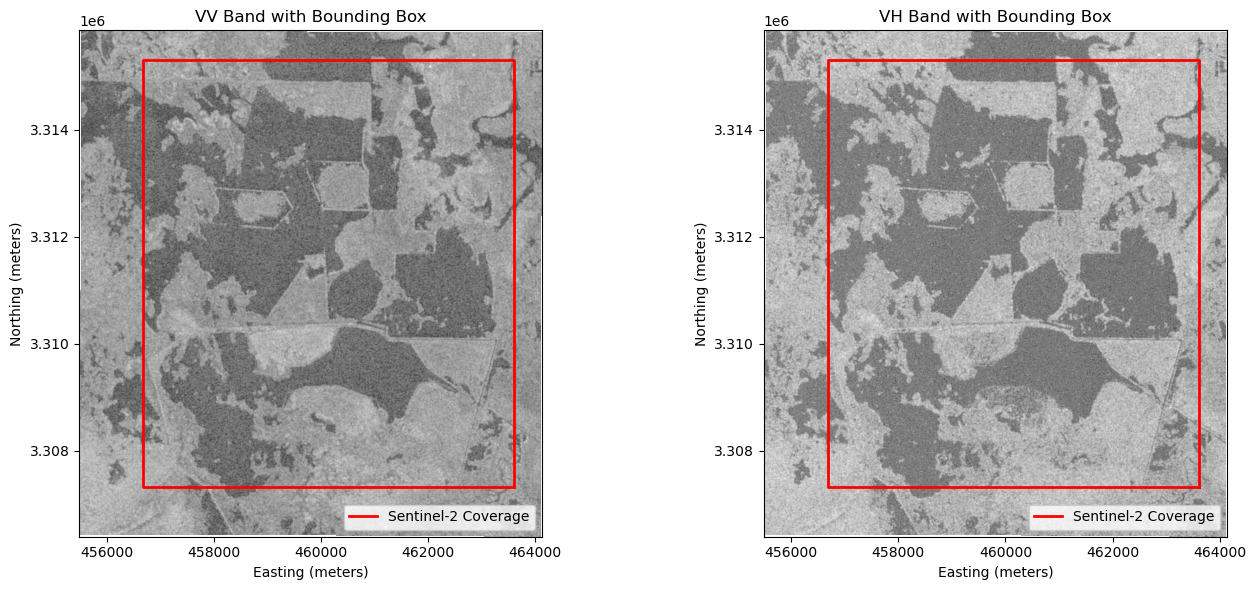

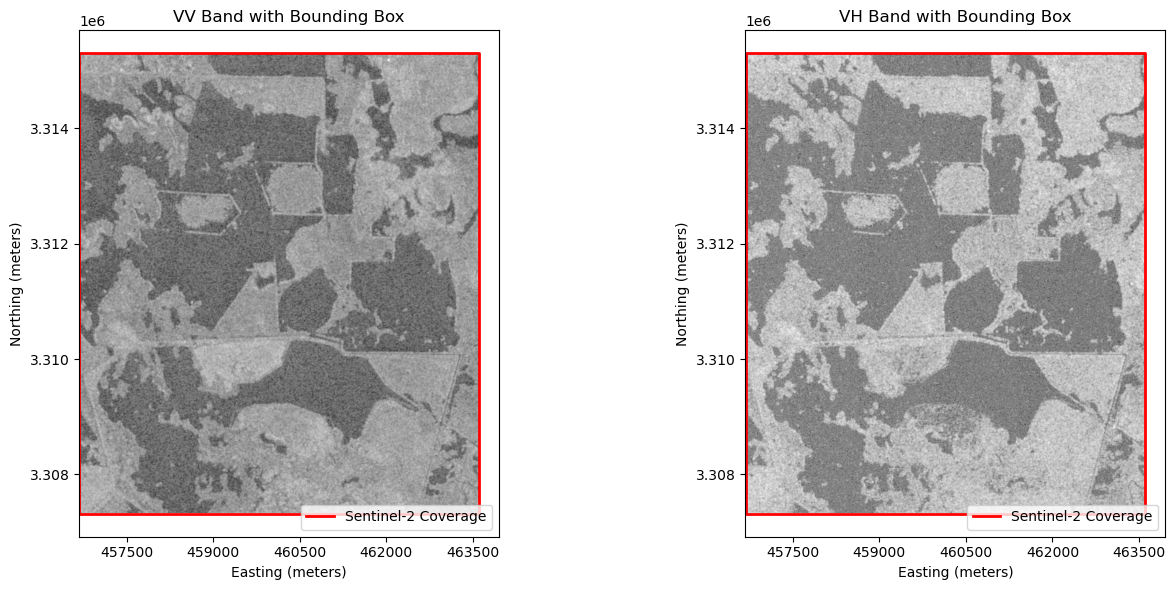

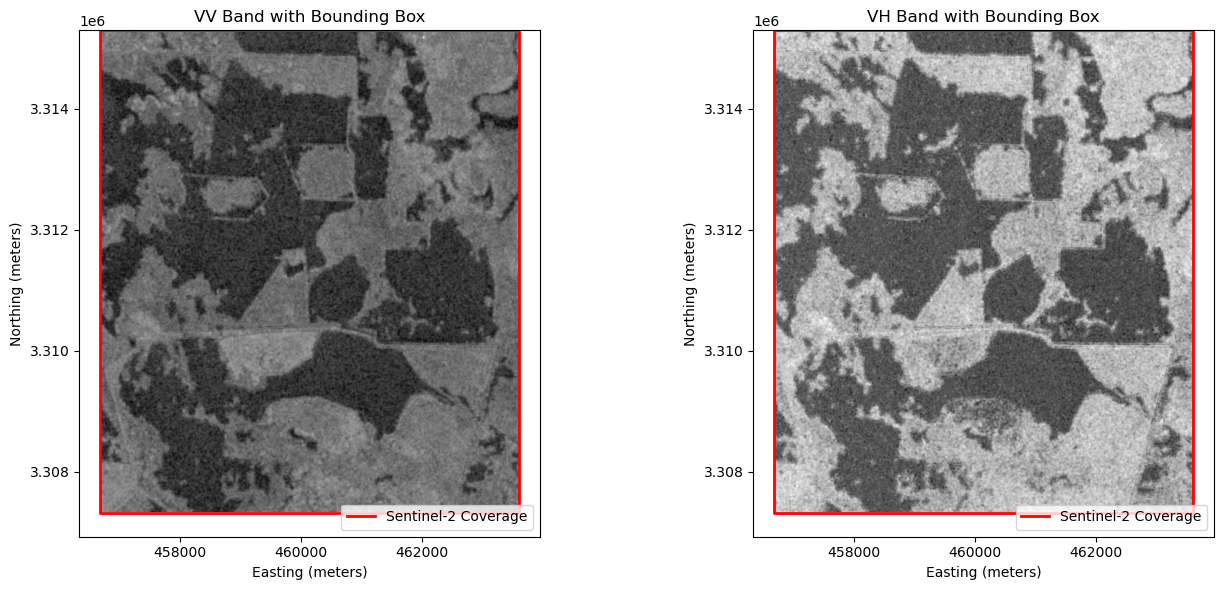

In [60]:
plot_vv_vh_with_bbox(orig_ims[0], bbox) # before clip
plot_vv_vh_with_bbox('/home/wcc/Desktop/SabineRS/GRD/2_clipped/backscatter/original/s1_2020-08-08.tif', bbox) # after clip
plot_vv_vh_with_bbox('/home/wcc/Desktop/SabineRS/GRD/2_clipped/backscatter/gammamap/s1_2020-08-08.tif', bbox) # after clip and reprojection for GammaMap filter

In [61]:
# get the reprojected and clipped data
clip_orig, clip_filt = get_grd('/home/wcc/Desktop/SabineRS/GRD/2_clipped/backscatter')
clip_orig_glcms, clip_filt_glcms = get_glcm('/home/wcc/Desktop/SabineRS/GRD/2_clipped/glcm')

# 2a. Register Sentinel-1 Imagery to Sentinel-2 labeled data?
- should be in same reference system, so not sure if they need to be registered

In [63]:
# register all sentinel-1 imagery to sentinel-2 reference image
# from my current understanding I will be registering all images to the first S2 image


In [ ]:
# use gdal.BuildVRT() to create new stacked rasters
# will be one raster for each time stamp that S1 and S2 are close in time
# will include the VV and VH, GLCM bands, and the four label rasters for each date ()

vrt_options = gdal.BuildVRTOptions()
gdal.BuildVRT()
gdal.Translate(.vrt, .tif)    # use this to go from .vrt to .tif?

# 2b. Label the Sentinel-1 data as land or water

In [ ]:
# check each labeled image to make sure the Subaerial Land = 1 and Water/Subaqeuous Land = 0


In [ ]:
# Label the S1 pixels as 0 or 1 depending on overlap with labeled image from S2


# 3. Save labeled S1 imagery for training Neural Network

In [ ]:
# save the S1 (original and filtered) with all bands in one image for training NN
# include VV, VH, GLCM, and the four classes for each pixel
